<a href="https://colab.research.google.com/github/Lorxus/dims_of_tmos/blob/main/toy_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toy Models of Superposition

This notebook includes the toy model training framework used to generate most of the results in the "Toy Models of Superposition" paper.

The main useful improvement over a basic PyTorch tiny autoencoder is the ability to batch train many models with varying sparsity at once, which is much more efficient than training them one at a time.

This notebook is designed to run in Google Colab's Python 3.7 environment.

In [ ]:
# !pip install einops

In [2]:
import torch
import torch as t
from torch import nn
from torch.nn import functional as F
from einops import einsum

from typing import Optional

from dataclasses import dataclass, replace
import numpy as np
import einops

from tqdm.notebook import trange

import time
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
import math

from sklearn.decomposition import PCA

if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

In [5]:
@dataclass
class Config:
    n_features: int
    n_hidden: int

    # We optimize n_instances models in a single training loop
    # to let us sweep over sparsity or importance curves
    # efficiently.

    # We could potentially use torch.vmap instead.
    n_instances: int


class Model(nn.Module):
    def __init__(
        self,
        config: Config,
        feature_probability: Optional[torch.Tensor] = None,
        importance: Optional[torch.Tensor] = None,
        device="cuda",
    ):
        super().__init__()
        self.config = config
        self.W = nn.Parameter(
            torch.empty(
                (config.n_instances, config.n_features, config.n_hidden), device=device
            )
        )
        nn.init.xavier_normal_(self.W)
        self.b_final = nn.Parameter(
            torch.zeros((config.n_instances, config.n_features), device=device)
        )

        if feature_probability is None:
            feature_probability = torch.ones(())
        self.feature_probability = feature_probability.to(device)
        if importance is None:
            importance = torch.ones(())
        self.importance = importance.to(device)

    def forward(self, features):
        # features: [..., instance, n_features]
        # W: [instance, n_features, n_hidden]
        hidden = torch.einsum("...if,ifh->...ih", features, self.W)
        out = torch.einsum("...ih,ifh->...if", hidden, self.W)
        out = out + self.b_final
        out = F.relu(out)
        return out

    def generate_batch(self, n_batch):
        feat = torch.rand(
            (n_batch, self.config.n_instances, self.config.n_features), device=self.W.device
        )
        batch = torch.where(
            torch.rand(
                (n_batch, self.config.n_instances, self.config.n_features),
                device=self.W.device,
            )
            <= self.feature_probability,
            feat,
            torch.zeros((), device=self.W.device),
        )
        return batch

In [6]:
def linear_lr(step, steps):
    return 1 - (step / steps)


def constant_lr(*_):
    return 1.0


def cosine_decay_lr(step, steps):
    return np.cos(0.5 * np.pi * step / (steps - 1))


def optimize(
    model: Model,
    render=False,
    n_batch=1024,
    steps=10_000,
    print_freq=100,
    lr=1e-3,
    lr_scale=constant_lr,
    hooks=[],
):
    cfg = model.config

    opt = torch.optim.AdamW(list(model.parameters()), lr=lr)

    start = time.time()
    with trange(steps) as t:
        for step in t:
            step_lr = lr * lr_scale(step, steps)
            for group in opt.param_groups:
                group["lr"] = step_lr
            opt.zero_grad(set_to_none=True)
            batch = model.generate_batch(n_batch)
            out = model(batch)
            error = model.importance * (batch.abs() - out) ** 2
            loss = einops.reduce(error, "b i f -> i", "mean").sum()
            loss.backward()
            opt.step()

            if hooks:
                hook_data = dict(
                    model=model, step=step, opt=opt, error=error, loss=loss, lr=step_lr
                )
                for h in hooks:
                    h(hook_data)
            if step % print_freq == 0 or (step + 1 == steps):
                t.set_postfix(
                    loss=loss.item() / cfg.n_instances,
                    lr=step_lr,
                )

## Introduction Figure

Reproducing a version of the figure from the introduction, although with a slightly different version of the code.

In [8]:
config = Config(
    n_features=5,
    n_hidden=2,
    n_instances=10,
)

model = Model(
    config=config,
    device=DEVICE,
    # Exponential feature importance curve from 1 to 1/100
    importance=(0.9 ** torch.arange(config.n_features))[None, :],
    # Sweep feature frequency across the instances from 1 (fully dense) to 1/20
    feature_probability=(20 ** -torch.linspace(0, 1, config.n_instances))[:, None],
)

In [9]:
optimize(model)

  0%|          | 0/10000 [00:00<?, ?it/s]

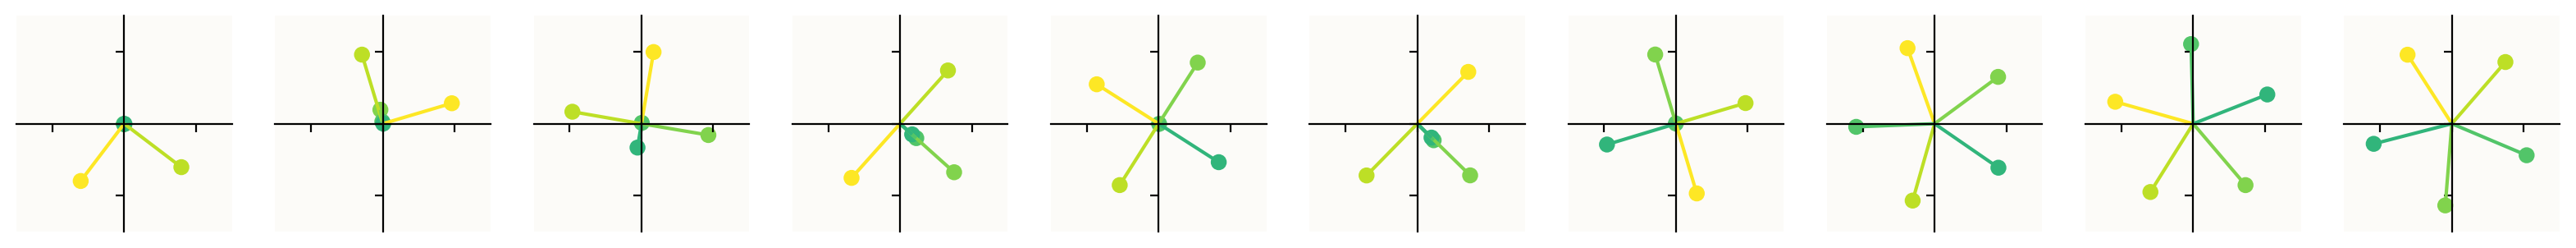

In [10]:
def plot_intro_diagram(model: Model):
    from matplotlib import colors as mcolors
    from matplotlib import collections as mc

    cfg = model.config
    WA = model.W.detach()
    N = len(WA[:, 0])
    sel = range(config.n_instances)  # can be used to highlight specific sparsity levels
    plt.rcParams["axes.prop_cycle"] = plt.cycler(
        "color", plt.cm.viridis(model.importance[0].cpu().numpy())
    )
    plt.rcParams["figure.dpi"] = 200
    fig, axs = plt.subplots(1, len(sel), figsize=(2 * len(sel), 2))
    for i, ax in zip(sel, axs):
        W = WA[i].cpu().detach().numpy()
        colors = [
            mcolors.to_rgba(c) for c in plt.rcParams["axes.prop_cycle"].by_key()["color"]
        ]
        ax.scatter(W[:, 0], W[:, 1], c=colors[0 : len(W[:, 0])])
        ax.set_aspect("equal")
        ax.add_collection(
            mc.LineCollection(np.stack((np.zeros_like(W), W), axis=1), colors=colors)
        )

        z = 1.5
        ax.set_facecolor("#FCFBF8")
        ax.set_xlim((-z, z))
        ax.set_ylim((-z, z))
        ax.tick_params(left=True, right=False, labelleft=False, labelbottom=False, bottom=True)
        for spine in ["top", "right"]:
            ax.spines[spine].set_visible(False)
        for spine in ["bottom", "left"]:
            ax.spines[spine].set_position("center")
    plt.show()


plot_intro_diagram(model)

# Visualizing features across varying sparsity

In [11]:
config = Config(
    n_features=100,
    n_hidden=20,
    n_instances=20,
)

model = Model(
    config=config,
    device=DEVICE,
    # Exponential feature importance curve from 1 to 1/100
    importance=(100 ** -torch.linspace(0, 1, config.n_features))[None, :],
    # Sweep feature frequency across the instances from 1 (fully dense) to 1/20
    feature_probability=(20 ** -torch.linspace(0, 1, config.n_instances))[:, None],
)

In [12]:
optimize(model)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [13]:
def render_features(model, which=np.s_[:]):
    cfg = model.config
    W = model.W.detach()
    W_norm = W / (1e-5 + torch.linalg.norm(W, 2, dim=-1, keepdim=True))

    interference = torch.einsum("ifh,igh->ifg", W_norm, W)
    interference[:, torch.arange(cfg.n_features), torch.arange(cfg.n_features)] = 0

    polysemanticity = torch.linalg.norm(interference, dim=-1).cpu()
    net_interference = (interference**2 * model.feature_probability[:, None, :]).sum(-1).cpu()
    norms = torch.linalg.norm(W, 2, dim=-1).cpu()

    WtW = torch.einsum("sih,soh->sio", W, W).cpu()

    # width = weights[0].cpu()
    # x = torch.cumsum(width+0.1, 0) - width[0]
    x = torch.arange(cfg.n_features)
    width = 0.9

    which_instances = np.arange(cfg.n_instances)[which]
    fig = make_subplots(
        rows=len(which_instances),
        cols=2,
        shared_xaxes=True,
        vertical_spacing=0.02,
        horizontal_spacing=0.1,
    )
    for row, inst in enumerate(which_instances):
        fig.add_trace(
            go.Bar(
                x=x,
                y=norms[inst],
                marker=dict(color=polysemanticity[inst], cmin=0, cmax=1),
                width=width,
            ),
            row=1 + row,
            col=1,
        )
        data = WtW[inst].numpy()
        fig.add_trace(
            go.Image(
                z=plt.cm.coolwarm((1 + data) / 2, bytes=True),
                colormodel="rgba256",
                customdata=data,
                hovertemplate="""\
In: %{x}<br>
Out: %{y}<br>
Weight: %{customdata:0.2f}
""",
            ),
            row=1 + row,
            col=2,
        )

    fig.add_vline(
        x=(x[cfg.n_hidden - 1] + x[cfg.n_hidden]) / 2,
        line=dict(width=0.5),
        col=1,
    )

    # fig.update_traces(marker_size=1)
    fig.update_layout(
        showlegend=False, width=600, height=100 * len(which_instances), margin=dict(t=0, b=0)
    )
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)
    return fig

In [14]:
fig = render_features(model, np.s_[::2])
fig.update_layout()

# Feature geometry

In [15]:
config = Config(
    n_features=400,
    n_hidden=30,
    n_instances=100,
)

left_val = 9 / 20
right_val = 11 / 20

model = Model(
    config=config,
    device=DEVICE,
    # For this experiment, use constant importance.
    # Sweep feature frequency across the instances from 1 (fully dense) to 1/20
    feature_probability=(20 ** -torch.linspace(left_val, right_val, config.n_instances))[
        :, None
    ],
)

In [16]:
optimize(model, steps=2_000, n_batch=2**13)  # ideally steps = 50k, batch size = 2^12

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
# left_val = math.log(3 / 4)
# right_val = math.log(4 / 5)


# feature_probability = (20 ** -torch.linspace(left_val, right_val, config.n_instances))[:, None]
# feature_probability
# 1 / (1 - feature_probability)

In [17]:
fig = px.line(
    x=1 / model.feature_probability[:, 0].cpu(),
    y=(model.config.n_hidden / (torch.linalg.matrix_norm(model.W.detach(), "fro") ** 2)).cpu(),
    log_x=True,
    markers=True,
)
fig.update_xaxes(title="1/(1-S)")
fig.update_yaxes(title=f"m/(||W||_F)^2")

In [18]:
@torch.no_grad()
def compute_dimensionality(W_SFN: t.Tensor) -> t.Tensor:
    norms_SF = torch.linalg.norm(W_SFN, 2, dim=-1)
    W_unit_SFN = W_SFN / torch.clamp(norms_SF[:, :, None], 1e-6, float("inf"))

    interferences_SF = (
        einsum(
            W_unit_SFN,
            W_SFN,
            "sparsity num_features1 num_neurons, sparsity num_features2 num_neurons -> sparsity num_features1 num_features2",
        )
        ** 2
    ).sum(-1)

    dim_fracs_SF = norms_SF**2 / interferences_SF
    return dim_fracs_SF.cpu()

def median_dimensionality(dim_fracs_SF: t.Tensor) -> t.Tensor:
    median_dim_frac: list[t.Tensor] = []
    for features in dim_fracs_SF:
        list_features = features.tolist()
        filtered_values = [features for features in list_features if 0.41 <= features <= 0.48]
        median_value = (
            t.median(t.tensor(filtered_values)) if len(filtered_values) > 0 else t.tensor(0)
        )
        median_dim_frac.append(median_value)

    median_dim_frac_tensor = t.stack(median_dim_frac)

    return median_dim_frac_tensor

In [26]:
dim_fracs_SF = compute_dimensionality(model.W)
median_dim_fracs_S = median_dimensionality(dim_fracs_SF)

In [21]:
fig = go.Figure()

density = model.feature_probability[:, 0].cpu()
W_SFN = model.W.detach()

for a, b in [(1, 2), (2, 3), (2, 5), (2, 6), (2, 7), (4, 9), (6, 13)]:
    val = a / b
    fig.add_hline(val, line_color="purple", opacity=0.2, annotation=dict(text=f"{a}/{b}"))

for a, b in [(1, 1), (3, 4), (3, 7), (3, 8), (3, 12), (3, 20), (5, 11), (5, 13), (4, 11)]:
    val = a / b
    fig.add_hline(
        val, line_color="blue", opacity=0.2, annotation=dict(text=f"{a}/{b}", x=0.05)
    )

for i in range(len(W_SFN)):
    fracs_ = dim_fracs_SF[i]
    N = fracs_.shape[0]
    xs = 1 / density
    if i != len(W_SFN) - 1:
        dx = xs[i + 1] - xs[i]
    fig.add_trace(
        go.Scatter(
            x=1 / density[i] * np.ones(N) + dx * np.random.uniform(-0.1, 0.1, N),
            y=fracs_,
            marker=dict(
                color="black",
                size=1,
                opacity=0.5,
            ),
            mode="markers",
        )
    )

    # fig.add_trace(
    #     go.Scatter(
    #         x=1 / density[i] * np.ones(N) + dx * np.random.uniform(-0.1, 0.1, N),
    #         y=[median_dim_fracs_S[i].item()],
    #         marker=dict(
    #             color="blue",
    #             size=10,
    #         ),
    #         mode="markers",
    #         marker_symbol="diamond-x",
    #     )
    # )

fig.update_xaxes(
    type="log",
    title="1/(1-S)",
    showgrid=False,
)
fig.update_yaxes(showgrid=False, title="hidden dimensions per embedded feature")
fig.update_layout({"title": "Effective dimensionality per feature vs. sparsity"})
fig.update_layout(showlegend=False)

In [ ]:
base_dir = "/mnt/ssd-1/mechinterp/koayon/ml-implementations/superposition/figures/"
fig.write_html(base_dir + "constrained_dimensionality_clusters1.html")

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/ssd-1/mechinterp/koayon/ml-implementations/superposition/figures/constrained_dimensionality_clusters1.html'

In [1]:
model.W.shape
GOOD_IDX = 39
# check for the traces in the "effective dim vs sparsity" graph above; use the indices that after you divide the trace by 2

W_SFN[GOOD_IDX]
# can put whichever index here in the brackets?
# the index here might not actually be the weight vectors for model #idx...

NameError: name 'model' is not defined

tensor([[-0.0076, -0.0163, -0.0015,  ..., -0.0138,  0.0069, -0.0091],
        [-0.0095, -0.0188, -0.0039,  ..., -0.0149,  0.0080, -0.0102],
        [-0.0085, -0.0210, -0.0042,  ..., -0.0196,  0.0090, -0.0089],
        ...,
        [-0.0069, -0.0152, -0.0037,  ..., -0.0134,  0.0072, -0.0116],
        [ 0.1075,  0.1825,  0.2653,  ..., -0.0038,  0.0667, -0.0290],
        [-0.0103, -0.0201, -0.0049,  ..., -0.0194,  0.0105, -0.0145]],
       device='cuda:0')

In [41]:
pca = PCA()
pca.fit(W_SFN[GOOD_IDX].T.cpu().numpy())

PCA()

In [42]:
pca_matrix_NF = pca.components_
# fig2 = px.imshow(np.abs(pca_matrix_NF[:]))
# fig2.show()

# Create a collection of heatmaps for each 20 features
fig = make_subplots(rows=5, cols=4, subplot_titles=[f"Feature {i}" for i in range(20)])

for i in range(20):
    fig.add_trace(
        go.Heatmap(
            z=np.abs(pca_matrix_NF[:, i * 20 : (i + 1) * 20]),
            colorscale="Viridis",
        ),
        row=i // 4 + 1,
        col=i % 4 + 1,
    )

fig.update_layout(height=1000, width=1000, title_text="PCA components for each 20 features")
fig.show()

In [ ]:
fig.write_html(base_dir + "separated_pca_matrix.html")

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/ssd-1/mechinterp/koayon/ml-implementations/superposition/figures/separated_pca_matrix.html'

In [43]:
def reorder_corr_matrix(corr_matrix: t.Tensor):
    # Get diagonal values
    diag_values = t.diagonal(corr_matrix)

    # Get indices that would sort the diagonal values in descending order
    sorted_indices = t.argsort(diag_values, descending=True)

    # Reorder both rows and columns using these indices
    reordered_matrix = corr_matrix[sorted_indices][:, sorted_indices]

    return reordered_matrix

W_GOOD_FN = W_SFN[GOOD_IDX].detach()
nfm_FF = W_GOOD_FN @ W_GOOD_FN.T
undiag_nfm_FF = nfm_FF # - t.diag(t.diag(nfm_FF))
print(t.max(t.abs(undiag_nfm_FF)))
diagf = nfm_FF.diag()
undiag_nfm_FF = reorder_corr_matrix(undiag_nfm_FF)
px.imshow(undiag_nfm_FF.cpu().numpy(), color_continuous_scale=px.colors.diverging.RdBu)

tensor(1.0830, device='cuda:0')


In [ ]:
threshold = 0.05

In [ ]:
pca_matrix_NF_tensor = t.tensor(pca_matrix_NF)
num_neurons_per_feature_F = t.sum((t.abs(pca_matrix_NF_tensor) > threshold).float(), dim=0)

In [ ]:
for i in range(20):
    print(i, t.sum((num_neurons_per_feature_F == i).float()).item())

In [ ]:
fig2.write_html(base_dir + "constrained_pca_matrix.html")

In [ ]:
pca2 = PCA()
pca2.fit(W_SFN[46].cpu().numpy())

In [ ]:
pca_matrix2 = pca2.components_
fig3 = px.imshow(pca_matrix2)
fig3.show()